![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Get data and import libraries

In [77]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [78]:
# QuantBook Analysis Tool
# For more information see [https://www.quantconnect.com/docs/v2/our-platform/research/getting-started]
qb = QuantBook()

qb.SetTimeZone(TimeZones.UTC)
start_time = datetime(2015, 5, 17)
end_time = datetime(2025, 5, 17)

btc = qb.AddCrypto("BTCUSD", Resolution.Daily)
sma20 = qb.SMA(btc.Symbol, 20, Resolution.Daily)
history = qb.history(btc.Symbol, start_time, end_time, Resolution.Daily).loc[btc.Symbol]
sma20_history = qb.IndicatorHistory(sma20, btc.Symbol, start_time, end_time, Resolution.Daily)

In [79]:
for point in sma20_history:
    history.loc[point.Time, 'SMA20'] = point.Value
    print(f"{point.Time}: {point.Value}")
    

In [80]:
history.head()

# Feature Engineering

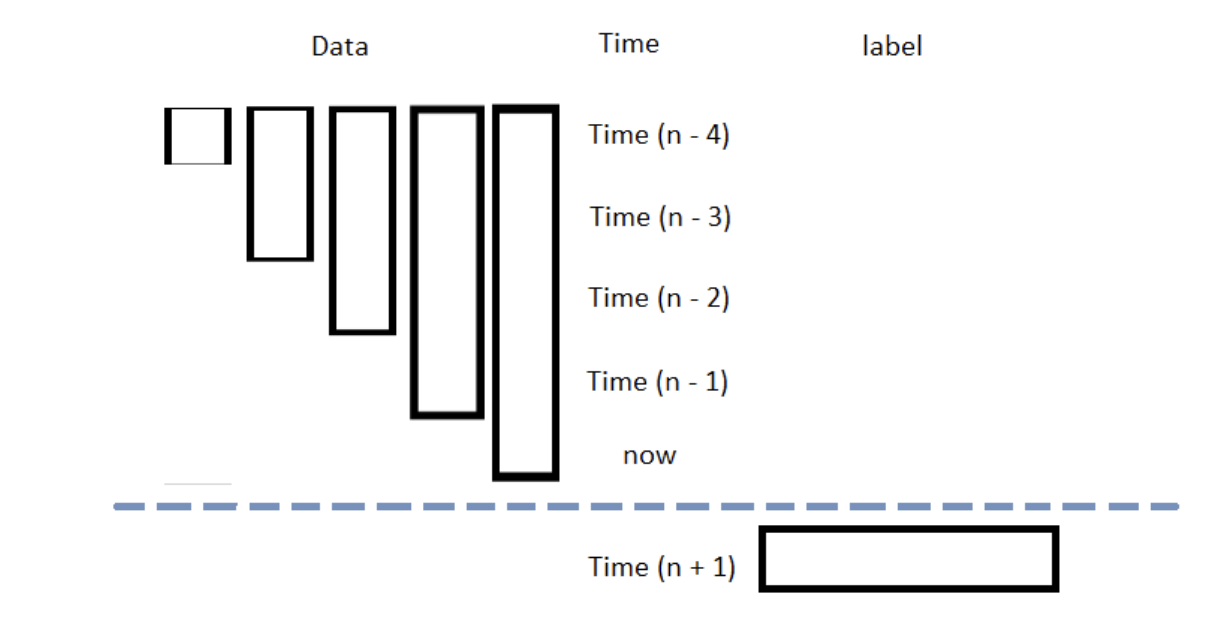

In [81]:
print(history["volume"][:10])

In [ ]:
data = history

# close differences with 1-5 day lags
lookback = 5
lookback_series = []
for i in range(1, lookback + 1):
    df = data["close"].diff(i)[lookback:-1] # -1 because of diff(-1) in Y
    df.name = f"close-lag-{i}"
    lookback_series.append(df)
X = pd.concat(lookback_series, axis = 1).reset_index(drop = True).dropna()
# add date
X["date"] = data.index[lookback:-1].to_series().reset_index(drop = True)
# add SMA20
X["SMA20"] = data["SMA20"][lookback:-1].reset_index(drop = True)
# add volume
X["volume"] = data["volume"][lookback:-1].reset_index(drop = True)
X

In [83]:
Y = data["close"].diff(-1)
print(Y[:10])

In [84]:
Y = Y[lookback:-1].reset_index(drop = True)
print(Y[:10])

In [85]:
print(history["close"][:10])
print(history["close"].diff(-1)[:10])

In [86]:
# remove date from X
X = X.drop(columns = ["date"])

# convert to numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()

print(X[:10], Y[:10])

In [87]:
print(history["close"][:10].diff())


In [88]:
X_scaled = StandardScaler().fit_transform(X)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.33, shuffle=False)

In [90]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [91]:
print(X_train[:5], y_train[:5])

# Train Neural Network

In [95]:
num_features = X.shape[1]
num_neurons_1 = 10
num_neurons_2 = 10
num_neurons_3 = 5
epochs = 1000
learning_rate = 1e-3

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_features,)),
    tf.keras.layers.Dense(num_neurons_1, activation='relu'),
    tf.keras.layers.Dense(num_neurons_2, activation='relu'),
    tf.keras.layers.Dense(num_neurons_3, activation='relu'),
    tf.keras.layers.Dense(1)  # linear activation for regression
]) 

In [97]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [98]:
model.fit(X_train, y_train, epochs=epochs, shuffle=False)

In [99]:
predictions = model.predict(X_test)

In [100]:
plt.plot(predictions[:100], label='Predictions')
plt.plot(y_test[:100], label='True Values')
plt.title('Close Price Difference Predictions vs Reality')
plt.legend()
plt.show()